# FairCLS
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HanXudong/Fair_NLP_Classification/blob/main/tutorial/demo.ipynb)

# Welcome to the FairCLS interactive tutorial

In this tutorial we will:
- Show how to install FairCLS, and prepare the preprocessed Moji sentiment analysis dataset.
- Show how to train a model with or without debiasing.
- Show how to analysis the results, including crating tables and figures
- Show how to run experiments over customized datasets.

## 1. Installation

Download the whl file for installation https://drive.google.com/file/d/1l3GmCm6UxbUh1QvMnfSrysdthFaFU-Eh/view?usp=sharing

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1l3GmCm6UxbUh1QvMnfSrysdthFaFU-Eh' -O 'faircls-0.0.1-py3-none-any.whl'

--2022-03-27 05:01:32--  https://docs.google.com/uc?export=download&id=1l3GmCm6UxbUh1QvMnfSrysdthFaFU-Eh
Resolving docs.google.com (docs.google.com)... 142.251.8.102, 142.251.8.101, 142.251.8.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/spu3du9lnjnvo4lpipb62vrr33auoo17/1648357275000/17527887236587461918/*/1l3GmCm6UxbUh1QvMnfSrysdthFaFU-Eh?e=download [following]
--2022-03-27 05:01:33--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/spu3du9lnjnvo4lpipb62vrr33auoo17/1648357275000/17527887236587461918/*/1l3GmCm6UxbUh1QvMnfSrysdthFaFU-Eh?e=download
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleus

In [2]:
!pip install faircls-0.0.1-py3-none-any.whl

Processing ./faircls-0.0.1-py3-none-any.whl
     |████████████████████████████████| 256 kB 4.0 MB/s 
     |████████████████████████████████| 3.8 MB 43.9 MB/s 
     |████████████████████████████████| 6.5 MB 31.0 MB/s 
     |████████████████████████████████| 895 kB 41.4 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import faircls

## 2. Prepare Dataset

In this notebook, we will be using the the Moji dataset, which can be downloaded and processed as follows:

In [4]:
import numpy as np
# from docopt import docopt
import os


def read_data_file(input_file: str):
    vecs = np.load(input_file)

    np.random.shuffle(vecs)

    return vecs[:40000], vecs[40000:42000], vecs[42000:44000]

In [5]:
!mkdir -p data/deepmoji
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_pos.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_neg.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/neg_pos.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/neg_neg.npy' -P 'data/deepmoji'

--2022-03-27 05:02:15--  https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_pos.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405494864 (387M) [application/octet-stream]
Saving to: ‘data/deepmoji/pos_pos.npy’

pos_pos.npy         100%[===================>] 386.71M  42.8MB/s    in 11s     

2022-03-27 05:02:29 (35.8 MB/s) - ‘data/deepmoji/pos_pos.npy’ saved [405494864/405494864]

--2022-03-27 05:02:29--  https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_neg.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405504080 (387M) [application/

In [6]:
in_dir = "data/deepmoji"
out_dir = "data/deepmoji"

os.makedirs(out_dir, exist_ok=True)

for split in ['pos_pos', 'pos_neg', 'neg_pos', 'neg_neg']:
    train, dev, test = read_data_file(in_dir + '/' + split + '.npy')
    for split_dir, data in zip(['train', 'dev', 'test'], [train, dev, test]):
        os.makedirs(out_dir + '/' + split_dir, exist_ok=True)
        np.save(out_dir + '/' + split_dir + '/' + split + '.npy', data)

## 3. Standard Usage

Here we provide an example of training a standard model without debiasing. 

In [7]:
Shared_options = {
    # The name of the dataset, correponding dataloader will be used,
    "dataset":  "Moji",

    # Specifiy the path to the input data
    "data_dir": "data/deepmoji",

    # Device for computing, -1 is the cpu
    "device_id":    -1,

    # The default path for saving experimental results
    "results_dir":  r"results",

    # The same as the dataset
    "project_dir":  r"dev",

    # We will focusing on TPR GAP, implying the Equalized Odds for binay classification.
    "GAP_metric_name":  "TPR_GAP",

    # The overall performance will be measured as accuracy
    "Performance_metric_name":  "accuracy",

    # Model selections are based on DTO
    "selection_criterion":  "DTO",

    # Default dirs for saving checkpoints
    "checkpoint_dir":   "models",
    "checkpoint_name":  "checkpoint_epoch",


    "n_jobs":   1,
}

In [8]:
!rm -rf results

In [9]:
args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"vanilla",
}

# Init the argument
options = faircls.BaseOptions()
state = options.get_state(args=args, silence=True)

INFO:root:Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-3c071458-aa92-4194-b195-ce6380125557.json']
INFO:root:Logging to ./results/dev/Moji/vanilla/output.log


2022-03-27 05:03:43 [INFO ]  ======================================== 2022-03-27 05:03:43 ========================================
2022-03-27 05:03:43 [INFO ]  Base directory is ./results/dev/Moji/vanilla
Loaded data shapes: (99998, 2304), (99998,), (99998,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7998, 2304), (7998,), (7998,)


In [10]:
# Init Model
model = faircls.networks.get_main_model(state)

2022-03-27 05:03:50 [INFO ]  MLP( 
2022-03-27 05:03:50 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-03-27 05:03:50 [INFO ]    (AF): Tanh()
2022-03-27 05:03:50 [INFO ]    (hidden_layers): ModuleList(
2022-03-27 05:03:50 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-03-27 05:03:50 [INFO ]      (1): Tanh()
2022-03-27 05:03:50 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-03-27 05:03:50 [INFO ]      (3): Tanh()
2022-03-27 05:03:50 [INFO ]    )
2022-03-27 05:03:50 [INFO ]    (criterion): CrossEntropyLoss()
2022-03-27 05:03:50 [INFO ]  )
2022-03-27 05:03:50 [INFO ]  Total number of parameters: 782402 



In [11]:
model.train_self()

2022-03-27 05:03:53 [INFO ]  Epoch:    0 [      0/  99998 ( 0%)]	Loss: 0.6954	 Data Time: 0.07s	Train Time: 0.30s
2022-03-27 05:03:57 [INFO ]  Epoch:    0 [  51200/  99998 (51%)]	Loss: 0.3577	 Data Time: 0.42s	Train Time: 3.36s
2022-03-27 05:04:01 [INFO ]  Evaluation at Epoch 0
2022-03-27 05:04:01 [INFO ]  Validation accuracy: 72.15	macro_fscore: 72.12	micro_fscore: 72.15	TPR_GAP: 37.98	FPR_GAP: 37.98	PPR_GAP: 37.25	
2022-03-27 05:04:01 [INFO ]  Test accuracy: 72.74	macro_fscore: 72.70	micro_fscore: 72.74	TPR_GAP: 38.12	FPR_GAP: 38.12	PPR_GAP: 37.41	
2022-03-27 05:04:01 [INFO ]  Epoch:    1 [      0/  99998 ( 0%)]	Loss: 0.3785	 Data Time: 0.02s	Train Time: 0.07s
2022-03-27 05:04:05 [INFO ]  Epoch:    1 [  51200/  99998 (51%)]	Loss: 0.3571	 Data Time: 0.41s	Train Time: 3.35s
2022-03-27 05:04:09 [INFO ]  Epochs since last improvement: 1
2022-03-27 05:04:09 [INFO ]  Evaluation at Epoch 1
2022-03-27 05:04:09 [INFO ]  Validation accuracy: 72.54	macro_fscore: 72.44	micro_fscore: 72.54	TPR_GA

In [12]:
debiasing_args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Exp name
    "exp_id":"BT_Adv",

    # Perform adversarial training if True
    "adv_debiasing":True,

    # Specify the hyperparameters for Balanced Training
    "BT":"Resampling",
    "BTObj":"EO",
}

debias_options = faircls.BaseOptions()
debias_state = debias_options.get_state(args=debiasing_args, silence=True)

debias_model = faircls.networks.get_main_model(debias_state)

2022-03-27 05:06:22 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-3c071458-aa92-4194-b195-ce6380125557.json']
2022-03-27 05:06:22 [INFO ]  Logging to ./results/dev/Moji/BT_Adv/output.log
2022-03-27 05:06:22 [INFO ]  ======================================== 2022-03-27 05:06:22 ========================================
2022-03-27 05:06:22 [INFO ]  Base directory is ./results/dev/Moji/BT_Adv
Loaded data shapes: (39996, 2304), (39996,), (39996,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7996, 2304), (7996,), (7996,)
2022-03-27 05:06:30 [INFO ]  SubDiscriminator( 
2022-03-27 05:06:30 [INFO ]    (grad_rev): GradientReversal()
2022-03-27 05:06:30 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-03-27 05:06:30 [INFO ]    (AF): ReLU()
2022-03-27 05:06:30 [INFO ]    (hidden_layers): ModuleList(
2022-03-27 05:06:30 [INFO ]      (0): Linear(in_features=300, out_features=300, bias=True)
2022-03-27 05:06:30 

In [13]:
# Around 90s
debias_model.train_self()

2022-03-27 05:06:35 [INFO ]  Epoch:    0 [      0/  39996 ( 0%)]	Loss: 0.0018	 Data Time: 0.02s	Train Time: 0.21s
2022-03-27 05:06:44 [INFO ]  Evaluation at Epoch 0
2022-03-27 05:06:44 [INFO ]  Validation accuracy: 75.04	macro_fscore: 75.02	micro_fscore: 75.04	TPR_GAP: 20.32	FPR_GAP: 20.32	PPR_GAP: 18.32	
2022-03-27 05:06:44 [INFO ]  Test accuracy: 75.63	macro_fscore: 75.59	micro_fscore: 75.63	TPR_GAP: 20.21	FPR_GAP: 20.21	PPR_GAP: 18.13	
2022-03-27 05:06:44 [INFO ]  Epoch:    1 [      0/  39996 ( 0%)]	Loss: -0.5065	 Data Time: 0.01s	Train Time: 0.21s
2022-03-27 05:06:53 [INFO ]  Epochs since last improvement: 1
2022-03-27 05:06:53 [INFO ]  Evaluation at Epoch 1
2022-03-27 05:06:53 [INFO ]  Validation accuracy: 71.85	macro_fscore: 71.38	micro_fscore: 71.85	TPR_GAP: 16.44	FPR_GAP: 16.44	PPR_GAP: 9.45	
2022-03-27 05:06:53 [INFO ]  Test accuracy: 72.21	macro_fscore: 71.78	micro_fscore: 72.21	TPR_GAP: 16.82	FPR_GAP: 16.82	PPR_GAP: 10.61	
2022-03-27 05:06:53 [INFO ]  Epoch:    2 [      0/  

## Analysis

In this section, we demonstrate the analysis module of FairCLS, which can be used for retriving results, selecting models, and comparing models.

Loading saved results. The saving dir is specified by the arguments when initialing the state for training. 

Briefly, the resulting dir is: `results_dir`/`project_dir`/`dataset`/`exp_id`.

The following example shows the information that has been stored for each epoch:

In [14]:
import torch

path = "{results_dir}/{project_dir}/{dataset}/{exp_id}/{checkpoint_dir}/{checkpoint_name}{epoch}.pth.tar"

path_vanilla_epoch0 = path.format(
    exp_id = "vanilla",
    epoch = "0",
    results_dir=Shared_options["results_dir"],
    project_dir=Shared_options["project_dir"],
    dataset=Shared_options["dataset"],
    checkpoint_dir=Shared_options["checkpoint_dir"],
    checkpoint_name=Shared_options["checkpoint_name"],
)

epoch_results = torch.load(path_vanilla_epoch0)
print(epoch_results.keys())

dict_keys(['epoch', 'epochs_since_improvement', 'loss', 'valid_confusion_matrices', 'test_confusion_matrices', 'dev_evaluations', 'test_evaluations'])


We currently save the following scores for performacne and fairness, other metrics can be calculated based to confusion matrices.

In [15]:
print(epoch_results["dev_evaluations"])

{'accuracy': 0.7215, 'macro_fscore': 0.7212364116044476, 'micro_fscore': 0.7215, 'TPR_GAP': 0.3797792083768608, 'FPR_GAP': 0.3797792140735489, 'PPR_GAP': 0.37249999906875003}


In [16]:
from faircls import analysis

`model_selection` is for retriving experiimental results, selecting the desired epoch, and save the resulting df for later process.

In [17]:
analysis.model_selection(
    model_id= ("vanilla"),
    index_column_names = ["BT", "BTObj", "adv_debiasing"],
    save_path = r"results/Vanilla_df.pkl",
    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,,,epoch,dev_fairness,dev_performance,dev_DTO,test_fairness,test_performance,test_DTO,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
NaN,NaN,False,15,0.667112,0.732125,0.0,0.677455,0.741685,0.0,results/dev/Moji/vanilla/opt.yaml


In [18]:
analysis.model_selection(
    model_id= ("BT_Adv"),
    index_column_names = ["BT", "BTObj", "adv_debiasing"],
    save_path = r"results/BT_ADV_df.pkl",
    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,,,epoch,dev_fairness,dev_performance,dev_DTO,test_fairness,test_performance,test_DTO,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
Resampling,EO,True,7,0.892943,0.7435,0.014416,0.907427,0.761256,0.006366,results/dev/Moji/BT_Adv/opt.yaml


We have preprocing the results with the `model_selection` function, and the resulting dfs can be downloaded as follows:

In [19]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl' -O retrived_results.tar.gz

--2022-03-27 05:08:32--  https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl
Resolving docs.google.com (docs.google.com)... 142.250.157.101, 142.250.157.113, 142.250.157.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.157.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/no0i0in95ds37g7ciiba64dnfoog69eq/1648357650000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download [following]
--2022-03-27 05:08:34--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/no0i0in95ds37g7ciiba64dnfoog69eq/1648357650000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.

In [20]:
!tar -xf retrived_results.tar.gz

Here we demostrate the application of `final_results_df`. We load chached results with `retrive_results`.

In [21]:
Moji_results = analysis.retrive_results("Moji", log_dir="analysis/results")

In [22]:
Moji_main_results = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = False,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    # Fairness_threshold=0.95,
    # return_conf=True,
    # save_conf_dir=r"D:\Project\Fair_NLP_Classification\analysis\reproduce\Moji"
    )
Moji_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO
0,Vanilla,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,0.476849
1,GatedAdv,0.753113,0.005196,0.890065,0.013302,0.748975,0.003805,0.910838,0.010314,0.270257
2,FairSCL,0.757314,0.003441,0.878219,0.004314,0.752825,0.001872,0.898325,0.002579,0.271527
3,FairBatch,0.751488,0.005772,0.904373,0.008213,0.746050,0.003896,0.914526,0.006020,0.266276
4,BTGatedAdv,0.735459,0.028830,0.866150,0.028232,0.730150,0.024594,0.886862,0.030537,0.296476
5,GDMean,0.752163,0.002130,0.901389,0.003916,0.749050,0.001368,0.922430,0.005829,0.266735
6,GatedDAdv,0.750163,0.006945,0.908679,0.021678,0.745600,0.004828,0.928670,0.022488,0.266004
7,INLP,0.733433,NaN,0.855982,NaN,0.727625,NaN,0.859686,NaN,0.302983
8,OldFairBatch,0.750638,0.006012,0.905537,0.005046,0.744525,0.004995,0.917734,0.004761,0.266655
9,DAdv,0.755464,0.004076,0.904023,0.011218,0.748550,0.002405,0.915601,0.005007,0.262697


In [23]:
print(Moji_main_results.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
        Models &  test\_performance mean &  test\_performance std &  test\_fairness mean &  test\_fairness std &  dev\_performance mean &  dev\_performance std &  dev\_fairness mean &  dev\_fairness std &      DTO \\
\midrule
       Vanilla &               0.722981 &              0.004576 &            0.611870 &           0.014356 &              0.726650 &             0.003673 &           0.632302 &          0.013370 & 0.476849 \\
      GatedAdv &               0.753113 &              0.005196 &            0.890065 &           0.013302 &              0.748975 &             0.003805 &           0.910838 &          0.010314 & 0.270257 \\
       FairSCL &               0.757314 &              0.003441 &            0.878219 &           0.004314 &              0.752825 &             0.001872 &           0.898325 &          0.002579 & 0.271527 \\
     FairBatch &               0.751488 &              0.005772 &            0.904373 &           0.008213 &  

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
def make_plot(plot_df, figure_name=None):
    plot_df["Fairness"] = plot_df["test_fairness mean"]
    plot_df["Accuracy"] = plot_df["test_performance mean"]

    figure = plt.figure(figsize=(6, 6), dpi = 150) 
    with sns.axes_style("white"):
        sns.lineplot(
            data=plot_df,
            x="Accuracy",
            y="Fairness",
            hue="Models",
            markers=True,
            style="Models",
        )
    if figure_name is not None:
        figure.savefig(Path(r"plots") / figure_name, dpi=960, bbox_inches="tight") 

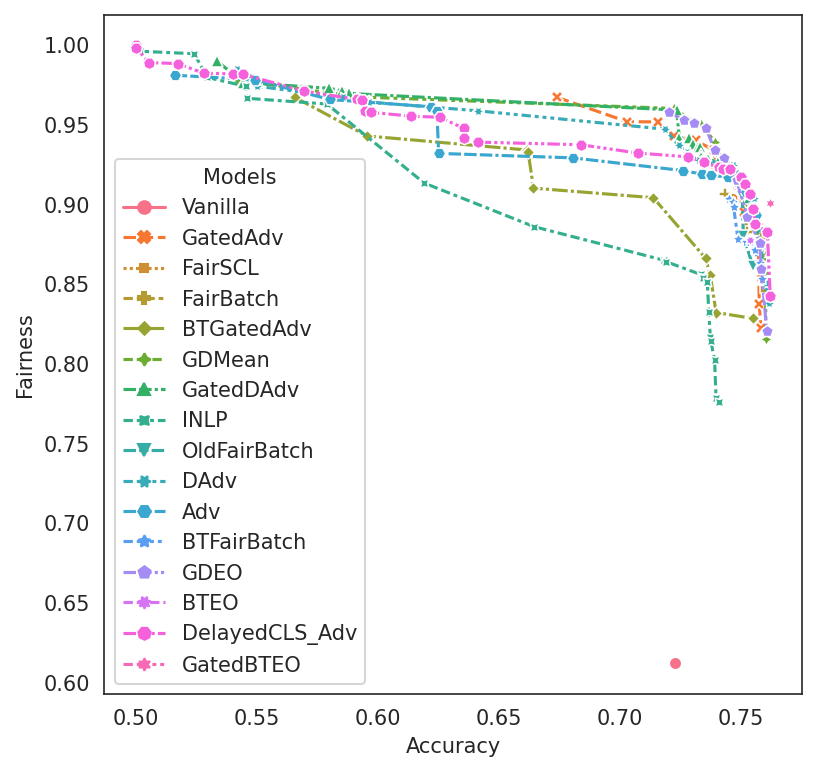

In [25]:
Moji_plot_df = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = True,
    # pareto = False,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    # Performance_threshold=0.72
    # num_trail=20,
    )
make_plot(Moji_plot_df)

## Customized Datasets and Models

In [34]:
from faircls import dataloaders

In [39]:
class CustomizedMojiDataset(dataloaders.utils.BaseDataset):

    p_aae = 0.5 # distribution of the main label, proportion of the AAE
    n = 12345 # target size

    def load_data(self):
        # stereotyping, 0.5 is balanced 
        if self.split == "train":
            self.ratio = 0.8 
        else:
            self.ratio = 0.5 # stereotyping, 0.5 is balanced 

        self.data_dir = Path(self.args.data_dir) / self.split

        n_1 = int(self.n * self.p_aae * self.ratio) # happy AAE 
        n_2 = int(self.n * (1-self.p_aae) * (1-self.ratio)) # happy SAE
        n_3 = int(self.n * self.p_aae * (1-self.ratio)) # unhappy AAE
        n_4 = int(self.n * (1-self.p_aae) * self.ratio) # unhappy SAE


        for file, label, protected, class_n in zip(['pos_pos', 'pos_neg', 'neg_pos', 'neg_neg'],
                                                                    [1, 1, 0, 0],
                                                                    [1, 0, 1, 0], 
                                                                    [n_1, n_2, n_3, n_4]
                                                                    ):
            data = np.load('{}/{}.npy'.format(self.data_dir, file))
            data = list(data[:class_n])
            self.X = self.X + data
            self.y = self.y + [label]*len(data)
            self.protected_label = self.protected_label + [protected]*len(data)

In [47]:
customized_dataset_args = {
    # "dataset":Shared_options["dataset"], 
    "dataset":"Customized", 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"customized_dataset",

    # Specify the hyperparameters for Balanced Training
    "BT":"Resampling",
    "BTObj":"EO",
}
customized_dataset_options = faircls.BaseOptions()
customized_dataset_state = customized_dataset_options.get_state(args=customized_dataset_args, silence=True)

customized_train_data = CustomizedMojiDataset(args=customized_dataset_state, split="train")
customized_dev_data = CustomizedMojiDataset(args=customized_dataset_state, split="dev")
customized_test_data = CustomizedMojiDataset(args=customized_dataset_state, split="test")

# DataLoader Parameters
tran_dataloader_params = {
        'batch_size': customized_dataset_state.batch_size,
        'shuffle': True,
        'num_workers': customized_dataset_state.num_workers}

eval_dataloader_params = {
        'batch_size': customized_dataset_state.test_batch_size,
        'shuffle': False,
        'num_workers': customized_dataset_state.num_workers}

# init dataloader
customized_training_generator = torch.utils.data.DataLoader(customized_train_data, **tran_dataloader_params)
customized_validation_generator = torch.utils.data.DataLoader(customized_dev_data, **eval_dataloader_params)
customized_test_generator = torch.utils.data.DataLoader(customized_test_data, **eval_dataloader_params)

2022-03-27 05:49:31 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-3c071458-aa92-4194-b195-ce6380125557.json']
2022-03-27 05:49:31 [INFO ]  Logging to ./results/dev/Customized/customized_dataset/output.log
2022-03-27 05:49:31 [WARNING]  Log file already exists, will append
2022-03-27 05:49:31 [INFO ]  ======================================== 2022-03-27 05:49:31 ========================================
2022-03-27 05:49:31 [INFO ]  Base directory is ./results/dev/Customized/customized_dataset
2022-03-27 05:49:31 [WARNING]  ./results/dev/Customized/customized_dataset/opt.yaml already exists, moved to ./results/dev/Customized/customized_dataset/old_opts/opt_2022_03_27__05_33_44.yaml
Not implemented
2022-03-27 05:49:31 [INFO ]  dataloaders need to be initialized!
Loaded data shapes: (4936, 2304), (4936,), (4936,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7996, 2304), (7996,), (7996,)


In [46]:
model_with_customized_dataset = faircls.networks.get_main_model(customized_dataset_state)
model_with_customized_dataset.train_self(
    train_generator = customized_training_generator,
    dev_generator = customized_validation_generator,
    test_generator = customized_test_generator,
)

2022-03-27 05:42:28 [INFO ]  MLP( 
2022-03-27 05:42:28 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-03-27 05:42:28 [INFO ]    (AF): Tanh()
2022-03-27 05:42:28 [INFO ]    (hidden_layers): ModuleList(
2022-03-27 05:42:28 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-03-27 05:42:28 [INFO ]      (1): Tanh()
2022-03-27 05:42:28 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-03-27 05:42:28 [INFO ]      (3): Tanh()
2022-03-27 05:42:28 [INFO ]    )
2022-03-27 05:42:28 [INFO ]    (criterion): CrossEntropyLoss()
2022-03-27 05:42:28 [INFO ]  )
2022-03-27 05:42:28 [INFO ]  Total number of parameters: 782402 

2022-03-27 05:42:28 [INFO ]  Epoch:    0 [      0/  12344 ( 0%)]	Loss: 0.6944	 Data Time: 0.03s	Train Time: 0.12s
2022-03-27 05:42:30 [INFO ]  Evaluation at Epoch 0
2022-03-27 05:42:30 [INFO ]  Validation accuracy: 72.40	macro_fscore: 72.25	micro_fscore: 72.40	TPR_GAP: 35.14	FPR_GAP: 35.14	PPR_GA